# Openset learning demo

Most is based on the paper:

Vaze, S., Han, K., Vedaldi, A. & Zisserman, A. Open-Set Recognition: a Good Closed-Set Classifier is All You Need? arXiv (2021) doi:10.48550/arxiv.2110.06207.

An important point is how to **organize the datasets and the models**:
$$D_{train} = \{(\vec{x_i}, y_i)\}_{i=1}^N \subset X \times C \text{, with } Model(\vec{x_i}) = p(y_i | \vec{x_i})$$
$$D_{test-closed} = \{(\vec{x_i}, y_i)\}_{i=1}^M \subset X \times C \text{, with } Model(\vec{x_i}) = p(y_i | \vec{x_i})$$
$$D_{test-open} = \{(\vec{x_i}, y_i)\}_{i=1}^{M'} \subset X \times (C \cup U) \text{, with } Model(\vec{x_i}) = (p(y_i | \vec{x_i}), S(y_i \subset C | \vec{x_i}))$$

It is trivial how to evaluate the `train` and `test-closed` scenarios.

First, let's pick the NDB1 problem and a positive and negative antigen.

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import NegativeClassOptimization.config as config
import NegativeClassOptimization.preprocessing as preprocessing
import NegativeClassOptimization.ml as ml

/home/eugen/miniconda3/envs/ab-negative-training/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The closed-set loop allows to train a model that outputs logits and expits (probability estimations). We will leverage that later for the openset scenario.

In [2]:
N = 10000

epochs = 5
learning_rate = 0.01
ag_pos = "1FBI"
ag_neg = "1NSN"

data_path = Path(config.DATA_SLACK_1_GLOBAL)

df = pd.read_csv(data_path, sep='\t')
df_closed = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy().sample(N)
df_open = df.loc[df["Antigen"].isin(config.ANTIGENS_OPENSET)].copy()
df_open = df_open.drop_duplicates(["Slide"], keep="first")
df_open = df_open.loc[~df_open["Slide"].isin(df_closed["Slide"])].sample(N)
df_open = df_open.reset_index(drop=True)

(   
    _,
    _,
    _,
    train_loader,
    test_loader,
    open_loader,
    ) = preprocessing.preprocess_data_for_pytorch_binary(
        df_closed,
        [ag_pos],
        scale_onehot=True,
        df_openset=df_open,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = ml.SN10().to(device)
print(model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

online_metrics = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses = ml.train_loop(train_loader, model, loss_fn, optimizer)
    test_metrics = ml.test_loop(test_loader, model, loss_fn)
    open_metrics = ml.openset_loop(open_loader, test_loader, model)
    online_metrics.append({
        "train_losses": losses,
        "test_metrics": test_metrics,
        "open_metrics": open_metrics,
    })

Using cpu device
SN10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=220, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)
Epoch 1
-------------------------------
loss: 0.668904  [    0/ 6599]
loss: 0.605455  [ 6400/ 6599]
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.611507 

Epoch 2
-------------------------------
loss: 0.606185  [    0/ 6599]
loss: 0.513376  [ 6400/ 6599]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.526647 

Epoch 3
-------------------------------
loss: 0.521537  [    0/ 6599]
loss: 0.407507  [ 6400/ 6599]
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.428558 

Epoch 4
-------------------------------
loss: 0.424176  [    0/ 6599]
loss: 0.312184  [ 6400/ 6599]
Test Error: 
 Accuracy: 92.7%, Avg loss: 0.343238 

Epoch 5
-------------------------------
loss: 0.340667  [    0/ 6599]
loss: 0.240395  [ 6400/ 6599]
Test Error: 
 Accuracy:

Computing logits and expits.

In [3]:
with torch.no_grad():
    print(f"""
    Logits: {model.forward_logits(test_loader.dataset[0][0])}
    Absolute logits: {abs(model.forward_logits(test_loader.dataset[0][0]))}
    Expits: {model.forward(test_loader.dataset[0][0])}
    Expits and logits: {model.forward(test_loader.dataset[0][0], return_logits=True)}
    """)


    Logits: tensor([[0.6340]])
    Absolute logits: tensor([[0.6340]])
    Expits: tensor([[0.6534]])
    Expits and logits: (tensor([[0.6534]]), tensor([[0.6340]]))
    


Closed set and open set evaluation.

In [4]:
for x in DataLoader(open_loader.dataset, batch_size=len(open_loader.dataset)):
    x = x

In [5]:
def compute_metrics_closed_testset(model, x_test, y_test):
    """Compute metrics for the closed test set.

    Args:
        model (torch.nn): implements forward_logits.
        x_test (torch.tensor): closed set input examples.
        y_test (torch.tensor): closed set output examples.

    Returns:
        dict: recorded relevant metrics.
    """
    assert hasattr(model, "forward_logits")

    y_test_logits = model.forward_logits(x_test).detach().numpy().reshape(-1)
    y_test_pred = model.forward(x_test).detach().numpy().reshape(-1).round()
    y_test_true = y_test.detach().numpy().reshape(-1)
    roc_auc_closed = metrics.roc_auc_score(y_true=y_test_true, y_score=y_test_logits)
    recall_closed = metrics.recall_score(y_true=y_test_true, y_pred=y_test_pred)
    precision_closed = metrics.precision_score(y_true=y_test_true, y_pred=y_test_pred)
    f1_closed = metrics.f1_score(y_true=y_test_true, y_pred=y_test_pred)
    metrics_closed = {
        "y_test_logits": y_test_logits,
        "y_test_pred": y_test_pred,
        "y_test_true": y_test_true,
        "roc_auc_closed": roc_auc_closed,
        "recall_closed": recall_closed,
        "precision_closed": precision_closed,
        "f1_closed": f1_closed,
    }
    return metrics_closed


def compute_metrics_open_testset(model, x_open, x_test):
    """Compute metrics for the open test set.

    Args:
        model (torch.nn): implements forward_logits.
        x_open (torch.tensor): open set input examples.
        x_test (torch.tensor): closed set input examples.

    Returns:
        dict: recorded metrics.
    """
    assert hasattr(model, "forward_logits")
    
    open_abs_logits = abs(model.forward_logits(x_open)).detach().numpy().reshape(-1)
    closed_abs_logits = abs(model.forward_logits(x_test).detach().numpy()).reshape(-1)
    df_tmp = pd.DataFrame(data=open_abs_logits, columns=["logits"])
    df_tmp = pd.concat(
        (
            pd.DataFrame(data={"abs_logits": open_abs_logits, "test_type": "open"}),
            pd.DataFrame(data={"abs_logits": closed_abs_logits, "test_type": "closed"})
        ),
        axis=0
    ).reset_index(drop=True)
    y_open_abs_logits = df_tmp["abs_logits"]
    df_tmp["y"] = np.where(df_tmp["test_type"] == "open", 0, 1)
    y_open_true = df_tmp["y"]
    del df_tmp
    roc_auc_open = metrics.roc_auc_score(y_true=y_open_true, y_score=y_open_abs_logits)
    metrics_open = {
        "y_open_abs_logits": y_open_abs_logits,
        "y_open_true": y_open_true,
        "roc_auc_open": roc_auc_open,
    }
    return metrics_open


def evaluate_on_closed_and_open_testsets(open_loader, test_loader, model):
    """Compute evaluation metrics for the closed set and open set
    scenarios.

    Args:
        open_loader (DataLoader): loads the open set testing dataset 
        which includes closed set and open set examples. Evaluated as
        a binary classification problem.

        test_loader (DataLoader): loads the typical closed set test data.
        
        model (torch.nn): the model to be evaluated. Must implement 
        forward_logits(x).
    """
    assert hasattr(model, "forward_logits")

    x, y = list(
        DataLoader(open_loader.dataset, batch_size=len(open_loader.dataset))
        )[0]
    x_test, y_test = list(
        DataLoader(test_loader.dataset, batch_size=len(test_loader.dataset))
        )[0]

    metrics_open = compute_metrics_open_testset(model, x, x_test)
    metrics_closed = compute_metrics_closed_testset(model, x_test, y_test)

    eval_metrics = {
        "open": metrics_open,
        "closed": metrics_closed,
    }
    return eval_metrics


eval_metrics = evaluate_on_closed_and_open_testsets(open_loader, test_loader, model)
eval_metrics

{'open': {'y_open_abs_logits': 0        1.625559
  1        1.216105
  2        1.891504
  3        0.717624
  4        1.275911
             ...   
  11645    1.811131
  11646    1.971816
  11647    0.102063
  11648    1.654843
  11649    1.766092
  Name: abs_logits, Length: 11650, dtype: float32,
  'y_open_true': 0        0
  1        0
  2        0
  3        0
  4        0
          ..
  11645    1
  11646    1
  11647    1
  11648    1
  11649    1
  Name: y, Length: 11650, dtype: int64,
  'roc_auc_open': 0.760590606060606},
 'closed': {'y_test_logits': array([ 0.6340364 ,  0.01702267,  0.6899904 , ..., -0.10206333,
          1.6548429 , -1.7660923 ], dtype=float32),
  'y_test_pred': array([1., 1., 1., ..., 0., 1., 0.], dtype=float32),
  'y_test_true': array([1., 1., 1., ..., 0., 1., 0.], dtype=float32),
  'roc_auc_closed': 0.9774570288159705,
  'recall_closed': 0.954653937947494,
  'precision_closed': 0.9280742459396751,
  'f1_closed': 0.9411764705882353}}

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Absolute logit distribution per open and closed set evaluation.\nNDB1(1FBI vs 1NSN)\n$N_{train} = $6599\n$N_{closed}$ = 1650\n$N_{open}$ = 10000'}, xlabel='abs_logits', ylabel='Probability'>)

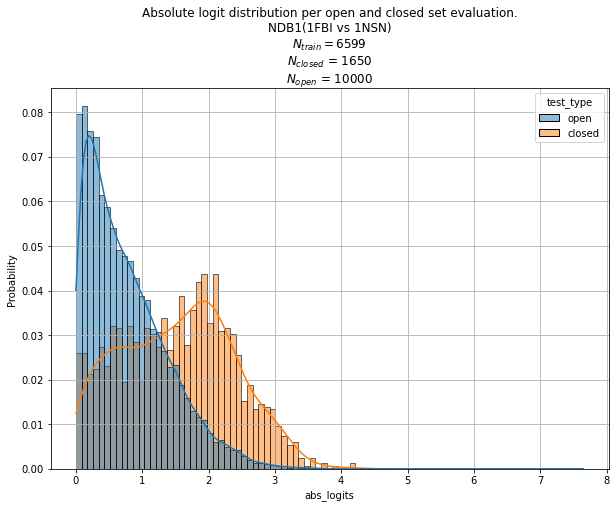

In [9]:
def plot_abs_logit_distr(eval_metrics):
    df_hist = pd.DataFrame(data={
        "abs_logits": eval_metrics["open"]["y_open_abs_logits"],
        "test_type": np.where(eval_metrics["open"]["y_open_true"] == 1, "closed", "open")
    })
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.histplot(data=df_hist, x="abs_logits", hue="test_type", stat="probability", ax=ax, common_norm=False, kde=True)
    ax.set_title(
        "Absolute logit distribution per open and closed set evaluation.\n"
        f"NDB1({ag_pos} vs {ag_neg})\n"
        r"$N_{train} = $"f"{len(train_loader.dataset)}\n"
        r"$N_{closed}$ = "f"{len(test_loader.dataset)}\n"
        r"$N_{open}$ = "f"{len(open_loader.dataset)}"
    )
    ax.grid()
    return (fig, ax)

plot_abs_logit_distr(eval_metrics)

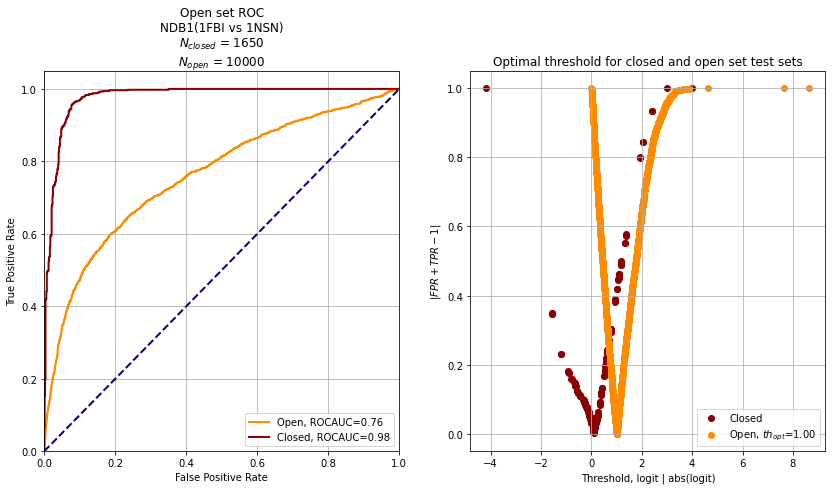

In [21]:
def find_optimal_threshold(fpr, tpr, thresholds) -> float:
    """Finds optimal threshold based on argmin(|FPR+TPR-1|).

    Returns:
        float: _description_
    """
    th_opt = thresholds[
        np.argmin(np.abs(fpr + tpr - 1))
    ]
    return th_opt


def plot_roc_open_and_closed_testsets(eval_metrics):
    """Plot ROC plots for the open and closed test sets evaluations.

    Args:
        eval_metrics (dict): contains the necessary metrics.

    Returns:
        (fig, axs)
    """    
    fpr_open, tpr_open, thresholds_open = metrics.roc_curve(
        y_true=eval_metrics["open"]["y_open_true"], 
        y_score=eval_metrics["open"]["y_open_abs_logits"],
    )
    th_open_opt = find_optimal_threshold(fpr_open, tpr_open, thresholds_open)

    fpr_closed, tpr_closed, thresholds_closed = metrics.roc_curve(
        y_true=eval_metrics["closed"]["y_test_true"], 
        y_score=eval_metrics["closed"]["y_test_logits"],
    )

    fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
    lw = 2
    axs[0].plot(
        fpr_open,
        tpr_open,
        color="darkorange",
        lw=lw,
        label=f'Open, ROCAUC={eval_metrics["open"]["roc_auc_open"]:.2f}',
    )
    axs[0].plot(
        fpr_closed,
        tpr_closed,
        color="darkred",
        lw=lw,
        label=f'Closed, ROCAUC={eval_metrics["closed"]["roc_auc_closed"]:.2f}',
    )
    axs[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title(
        "Open set ROC\n"
        f"NDB1({ag_pos} vs {ag_neg})\n"
        r"$N_{closed}$ = "f"{len(test_loader.dataset)}\n"
        r"$N_{open}$ = "f"{len(open_loader.dataset)}"
    )
    axs[0].legend(loc="lower right")
    axs[0].grid()

    axs[1].scatter(
        thresholds_closed, 
        np.abs(fpr_closed + tpr_closed - 1), 
        label="Closed", 
        color="darkred"
    )
    axs[1].scatter(
        thresholds_open, 
        np.abs(fpr_open + tpr_open - 1), 
        label=r"Open, $th_{opt}$="f"{th_open_opt:.2f}", 
        color="darkorange"
    )
    axs[1].legend(loc="lower right")
    axs[1].set_xlabel("Threshold, logit | abs(logit)")
    axs[1].set_ylabel("$|FPR+TPR-1|$")
    axs[1].set_title("Optimal threshold for closed and open set test sets")
    axs[1].grid()
    return (fig, axs)


fig, _ = plot_roc_open_and_closed_testsets(eval_metrics)
fig.show()